1.IMPORT LIBRARIES

In [1]:
# pip install -r requirements.txt

zsh:1: command not found: pip


In [48]:
# Core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import MSELoss
# Data handling
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics & utilities
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Progress & debugging
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import glob
import joblib

device = "mps" if torch.backends.mps.is_available() else "cpu"


2.DATA LOADER AND CREATE SEQUENCES

In [49]:
all_files = sorted(glob.glob("data/monthly_hourly_load_values_*.xlsx"))
df_list = [pd.read_excel(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)
df['DateUTC'] = pd.to_datetime(df['DateUTC'])
df.set_index('DateUTC', inplace=True)

# Training: 2019–2024, Testing: 2025
train_df_full = df[df.index.year < 2025]
test_df = df[df.index.year == 2025]

# Split validation from end of 2024 (10% of training)
val_ratio = 0.1
val_size = int(len(train_df_full) * val_ratio)
val_df = train_df_full.iloc[-val_size:]
train_df = train_df_full.iloc[:-val_size]

def create_sequences(data, seq_len=24, output_len=1):
    X, y = [], []
    for i in range(seq_len, len(data) - output_len + 1):
        X.append(data[i - seq_len:i])
        y.append(data[i:i + output_len].flatten())
    return np.array(X), np.array(y)

scaler = StandardScaler()
scaler.fit(df[['Value']])
joblib.dump(scaler, 'scaler.pkl')
train_df['Value_normalized'] = scaler.transform(train_df[['Value']])
val_df['Value_normalized']   = scaler.transform(val_df[['Value']])
test_df['Value_normalized'] = scaler.transform(test_df[['Value']])


def prepare_multi_country_data_global_correct(df, sequence_length=24, prediction_length=1, 
                                             dataset_name="dataset"):
    """
    CORRECT: Use the same scaler for all datasets (fitted only on training data)
    """
    print(f"\n{'='*50}")
    print(f"PREPARING {dataset_name.upper()}")
    print(f"{'='*50}")
    
    df_clean = df.dropna(subset=['Value']).copy()
   
    

    # Sort by country and date
    df_clean = df_clean.sort_values(['CountryCode', 'DateUTC']).reset_index(drop=False)
    
    sequences = []
    targets = []
    countries = []
    timestamps = []

    # Create sequences for each country separately but pool them together
    for country in df_clean['CountryCode'].unique():
        country_data = df_clean[df_clean['CountryCode'] == country]
        values = country_data['Value_normalized'].values
        dates = country_data['DateUTC'].values
        sequences, targets = create_sequences(
            values, seq_len=sequence_length, output_len=prediction_length
        )

    X = np.array(sequences)
    y = np.array(targets)
    countries = np.array(countries)
    timestamps = np.array(timestamps)

    print(f"\nFinal dataset stats:")
    print(f"Total sequences: {len(X):,}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Normalized X range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"Normalized y range: [{y.min():.3f}, {y.max():.3f}]")
    
    # Check country distribution
    unique_countries, counts = np.unique(countries, return_counts=True)
    print(f"\nCountry distribution in sequences:")
    for country, count in zip(unique_countries, counts):
        print(f"  {country}: {count:,} sequences ({count/len(X)*100:.1f}%)")
    
    return X, y

X_train, y_train = prepare_multi_country_data_global_correct(
    train_df, sequence_length=24, prediction_length=1
)

X_val, y_val= prepare_multi_country_data_global_correct(
    val_df, sequence_length=24, prediction_length=1
)

X_test, y_test = prepare_multi_country_data_global_correct(
    test_df, sequence_length=24, prediction_length=1
)

print(f"All datasets normalized with the same scaler")
print(f"Train range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Val range:   [{X_val.min():.3f}, {X_val.max():.3f}]")
print(f"Test range:  [{X_test.min():.3f}, {X_test.max():.3f}]")



PREPARING DATASET

Final dataset stats:
Total sequences: 20,684
X shape: (20684, 24)
y shape: (20684, 1)
Normalized X range: [-0.713, -0.613]
Normalized y range: [-0.713, -0.613]

Country distribution in sequences:

PREPARING DATASET

Final dataset stats:
Total sequences: 8,754
X shape: (8754, 24)
y shape: (8754, 1)
Normalized X range: [-0.694, -0.611]
Normalized y range: [-0.694, -0.611]

Country distribution in sequences:

PREPARING DATASET

Final dataset stats:
Total sequences: 4,320
X shape: (4320, 24)
y shape: (4320, 1)
Normalized X range: [-0.693, -0.612]
Normalized y range: [-0.693, -0.612]

Country distribution in sequences:
All datasets normalized with the same scaler
Train range: [-0.713, -0.613]
Val range:   [-0.694, -0.611]
Test range:  [-0.693, -0.612]


3.MODEL

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualBranchTFT(nn.Module):
    def __init__(self, sequence_length, prediction_length, hidden_size=64, num_layers=2, 
                 dropout=0.1, conv_kernels=[3, 7, 15], num_attention_heads=4):
        super().__init__()
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.hidden_size = hidden_size
        
        self.trend_branch = TrendExtractionBranch(
            input_size=1,
            hidden_size=hidden_size,
            conv_kernels=conv_kernels,
            dropout=dropout
        )
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_attention_heads,
            dropout=dropout,
            batch_first=True
        )
        
        self.fusion_type = "gated"  # Options: "concat", "gated", "weighted"
        
        if self.fusion_type == "concat":
            self.fusion_output_size = hidden_size * 2
            self.fusion_projection = nn.Linear(hidden_size * 2, hidden_size)
        elif self.fusion_type == "gated":
            self.fusion_gate = nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Sigmoid()
            )
            self.fusion_output_size = hidden_size
        elif self.fusion_type == "weighted":
            self.fusion_weights = nn.Parameter(torch.ones(2))  # Two branches
            self.fusion_output_size = hidden_size
        
        # Layer normalizations
        self.lstm_norm = nn.LayerNorm(hidden_size)
        self.fusion_norm = nn.LayerNorm(self.fusion_output_size)
        self.output_layer = nn.Sequential(
            nn.Linear(self.fusion_output_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, prediction_length)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, 1)
        batch_size = x.size(0)
        
        trend_features = self.trend_branch(x)  # (batch_size, hidden_size)
        
        # LSTM encoding
        lstm_output, (hidden, cell) = self.encoder_lstm(x)
        lstm_output = self.lstm_norm(lstm_output)
        
        # Self-attention on LSTM outputs
        attended_output, attention_weights = self.attention(
            lstm_output, lstm_output, lstm_output
        )
        
        # Get the final temporal representation (last time step)
        temporal_features = attended_output[:, -1, :]  # (batch_size, hidden_size)
        
        if self.fusion_type == "concat":
            # Simple concatenation with projection
            fused_features = torch.cat([trend_features, temporal_features], dim=-1)
            fused_features = self.fusion_projection(fused_features)
            
        elif self.fusion_type == "gated":
            # Gated fusion - learn which branch to trust more
            combined = torch.cat([trend_features, temporal_features], dim=-1)
            gate = self.fusion_gate(combined)
            fused_features = gate * trend_features + (1 - gate) * temporal_features
            
        elif self.fusion_type == "weighted":
            # Weighted sum of branches
            weights = F.softmax(self.fusion_weights, dim=0)
            fused_features = weights[0] * trend_features + weights[1] * temporal_features
        
        fused_features = self.fusion_norm(fused_features)
        
        output = self.output_layer(fused_features)  # (batch_size, prediction_length)
        
        return output


class TrendExtractionBranch(nn.Module):
    """CNN-based branch for multi-scale trend extraction"""
    
    def __init__(self, input_size, hidden_size, conv_kernels=[3, 7, 15], dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.conv_kernels = conv_kernels
        self.num_kernels = len(conv_kernels)
    
        # Use divisible allocation
        base_channels = hidden_size // self.num_kernels
        remainder = hidden_size % self.num_kernels
        self.output_channels = [base_channels + (1 if i < remainder else 0) 
                              for i in range(self.num_kernels)]
        
        # Parallel convolutional layers with different kernel sizes
        self.conv_layers = nn.ModuleList()
        for i, kernel_size in enumerate(conv_kernels):
            padding = (kernel_size - 1) // 2  # Same padding
            conv_block = nn.Sequential(
                nn.Conv1d(
                    in_channels=input_size,
                    out_channels=self.output_channels[i],
                    kernel_size=kernel_size,
                    padding=padding,
                    padding_mode='replicate'
                ),
                nn.BatchNorm1d(self.output_channels[i]),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.conv_layers.append(conv_block)
        
        # Global pooling to get trend representation
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Feature projection to ensure correct hidden_size
        self.feature_projection = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_size)
        )
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, 1)
        # Rearrange for conv1d: (batch_size, channels, sequence_length)
        x_conv = x.transpose(1, 2)  # (batch_size, 1, sequence_length)
        
        # Apply parallel convolutions
        conv_outputs = []
        for conv_layer in self.conv_layers:
            conv_out = conv_layer(x_conv)  # (batch_size, output_channel_i, seq_len)
            conv_outputs.append(conv_out)
        
        # Concatenate along channel dimension
        combined_conv = torch.cat(conv_outputs, dim=1)  # (batch_size, hidden_size, seq_len)
        
        # Global average pooling to get trend representation
        trend_rep = self.global_pool(combined_conv)  # (batch_size, hidden_size, 1)
        trend_rep = trend_rep.squeeze(-1)  # (batch_size, hidden_size)
        
        # Final projection to ensure correct dimensions
        trend_features = self.feature_projection(trend_rep)  # (batch_size, hidden_size)
        
        return trend_features


sequence_length = 24
prediction_length = 1
hidden_size =128

# Initialize the dual-branch model
model = DualBranchTFT(
    sequence_length=sequence_length,
    prediction_length=prediction_length,
    hidden_size=hidden_size,
    num_layers=2,
    dropout=0.1,
    conv_kernels=[3, 7, 15]  # Multi-scale trend extraction
)


4.TRAINING PIPELINE

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, learning_rate=1e-4):
    """
    Simple PyTorch training function with tqdm progress bars
    """
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model.to(device)
    
    # Convert data to tensors
    if isinstance(X_train, np.ndarray):
        X_train = torch.FloatTensor(X_train)
    if isinstance(y_train, np.ndarray):
        y_train = torch.FloatTensor(y_train)
    if isinstance(X_val, np.ndarray):
        X_val = torch.FloatTensor(X_val)
    if isinstance(y_val, np.ndarray):
        y_val = torch.FloatTensor(y_val)
    
    # Create DataLoaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    print("Starting training...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        # Create progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            
            # Add channel dimension if needed (batch_size, seq_len) -> (batch_size, seq_len, 1)
            if len(data.shape) == 2:
                data = data.unsqueeze(-1)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.6f}',
                'Avg Loss': f'{train_loss/(batch_idx+1):.6f}'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
        
        with torch.no_grad():
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                if len(data.shape) == 2:
                    data = data.unsqueeze(-1)
                
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                
                # Update validation progress bar
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.6f}',
                    'Avg Loss': f'{val_loss/(len(val_pbar)+1):.6f}'
                })
        
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    print("Training completed!")
    return model,history

In [12]:
# model.load_state_dict(torch.load('model_state_dict.pth'))
model,history = train_model(model, X_train, y_train,X_val,y_val, epochs=10)

Using device: mps
Starting training...


Epoch 1/10 [Train]:   0%|          | 0/51536 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/5714 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.008193, Val Loss: 0.002151


Epoch 2/10 [Train]:   0%|          | 0/51536 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/5714 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.005513, Val Loss: 0.001494


Epoch 3/10 [Train]:   0%|          | 0/51536 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/5714 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.005084, Val Loss: 0.001133


Epoch 4/10 [Train]:   0%|          | 0/51536 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/5714 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.004913, Val Loss: 0.001242


Epoch 5/10 [Train]:   0%|          | 0/51536 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/5714 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.004816, Val Loss: 0.001698


Epoch 6/10 [Train]:   0%|          | 0/51536 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/5714 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.004753, Val Loss: 0.001689


Epoch 7/10 [Train]:   0%|          | 0/51536 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/5714 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.004693, Val Loss: 0.001322


Epoch 8/10 [Train]:   0%|          | 0/51536 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/5714 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.004659, Val Loss: 0.001403


Epoch 9/10 [Train]:   0%|          | 0/51536 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/5714 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.004600, Val Loss: 0.001366


Epoch 10/10 [Train]:   0%|          | 0/51536 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/5714 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.004555, Val Loss: 0.001610
Training completed!


In [13]:
torch.save(model.state_dict(),"model_state_dict.pth")

In [21]:
def evaluate_model(y_true, y_pred, scaler=None):
    # Remove any extra dimensions but keep the prediction_length dimension
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    # Store original shapes for debugging
    original_shape_true = y_true.shape
    original_shape_pred = y_pred.shape
    
    print(f"Debug - y_true shape: {original_shape_true}, y_pred shape: {original_shape_pred}")
    
    if scaler:
        # For multi-step forecasting, we need to handle each time step separately
        # or flatten, transform, then reshape back
        if len(y_true.shape) > 1:
            # Multi-step forecasting - flatten, transform, then reshape back
            true_flat = y_true.reshape(-1, 1)
            pred_flat = y_pred.reshape(-1, 1)
            
            y_true = scaler.inverse_transform(true_flat).reshape(y_true.shape)
            y_pred = scaler.inverse_transform(pred_flat).reshape(y_pred.shape)
        else:
            # Single-step forecasting
            y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
            y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Handle MAPE carefully to avoid division by zero
    # Use np.where to avoid division by very small numbers
    with np.errstate(divide='ignore', invalid='ignore'):
        ape = np.abs((y_true - y_pred) / np.where(np.abs(y_true) < 1e-8, 1e-8, y_true))
        mape = np.mean(ape) * 100
    
    print(f"Debug - After inverse - y_true range: [{y_true.min():.2f}, {y_true.max():.2f}]")
    print(f"Debug - After inverse - y_pred range: [{y_pred.min():.2f}, {y_pred.max():.2f}]")
    
    return round(rmse, 2), round(mae, 2), round(mape, 2), y_true, y_pred

def test_model(model, X_test, y_test, batch_size=32, scaler=None):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    if isinstance(X_test, np.ndarray):
        X_test = torch.FloatTensor(X_test)
    if isinstance(y_test, np.ndarray):
        y_test = torch.FloatTensor(y_test)
    
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Testing'):
            data, target = data.to(device), target.to(device)
            if len(data.shape) == 2:
                data = data.unsqueeze(-1)
            
            output = model(data)
            all_preds.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Debug: Check shapes before evaluation
    print(f"Before evaluation - all_targets shape: {all_targets.shape}")
    print(f"Before evaluation - all_preds shape: {all_preds.shape}")
    print(f"Before evaluation - all_targets range: [{all_targets.min():.3f}, {all_targets.max():.3f}]")
    print(f"Before evaluation - all_preds range: [{all_preds.min():.3f}, {all_preds.max():.3f}]")
    
    rmse, mae, mape, y_true_inv, y_pred_inv = evaluate_model(all_targets, all_preds, scaler=scaler)
    
    print(f"Test RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'y_true': y_true_inv,
        'y_pred': y_pred_inv
    }

In [65]:
checkpoint = torch.load('model_state_dict.pth',weights_only=True, map_location=device)
model.load_state_dict(checkpoint)
scaler = StandardScaler()
scaler = joblib.load('scaler.pkl')

results = test_model(model, X_test, y_test, batch_size=32,scaler=scaler)



Testing: 100%|██████████| 135/135 [00:00<00:00, 184.28it/s]

Before evaluation - all_targets shape: (4320, 1)
Before evaluation - all_preds shape: (4320, 1)
Before evaluation - all_targets range: [-0.693, -0.612]
Before evaluation - all_preds range: [-0.683, -0.608]
Debug - y_true shape: (4320,), y_pred shape: (4320,)
Debug - After inverse - y_true range: [311.43, 1418.44]
Debug - After inverse - y_pred range: [448.91, 1471.95]
Test RMSE: 124.56, MAE: 114.57, MAPE: 17.860000610351562%


In [78]:
import matplotlib.pyplot as plt

def plot_partial_predictions(y_true, preds_dict, split_idx=0, group_title="Predictions", window_size=1000, start_idx=0):
    """
    Plots a window of true vs predicted values for time series.
    Args:
        y_true: np.array, true values (already inverse-scaled)
        preds_dict: np.array, predicted values
        split_idx: int, index to split train/test (optional, for marking)
        group_title: str, plot title
        window_size: int, number of points to show
        start_idx: int, starting index for the window
    """
    end_idx = start_idx + window_size
    plt.figure(figsize=(15, 5))
    plt.plot(range(start_idx, end_idx), y_true[start_idx:end_idx], label="True", linewidth=2)
    plt.plot(range(start_idx, end_idx), preds_dict[start_idx:end_idx], label="Predicted", linewidth=2)
    if split_idx > start_idx and split_idx < end_idx:
        plt.axvline(split_idx, color='r', linestyle='--', label='Test Split')
    plt.title(group_title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

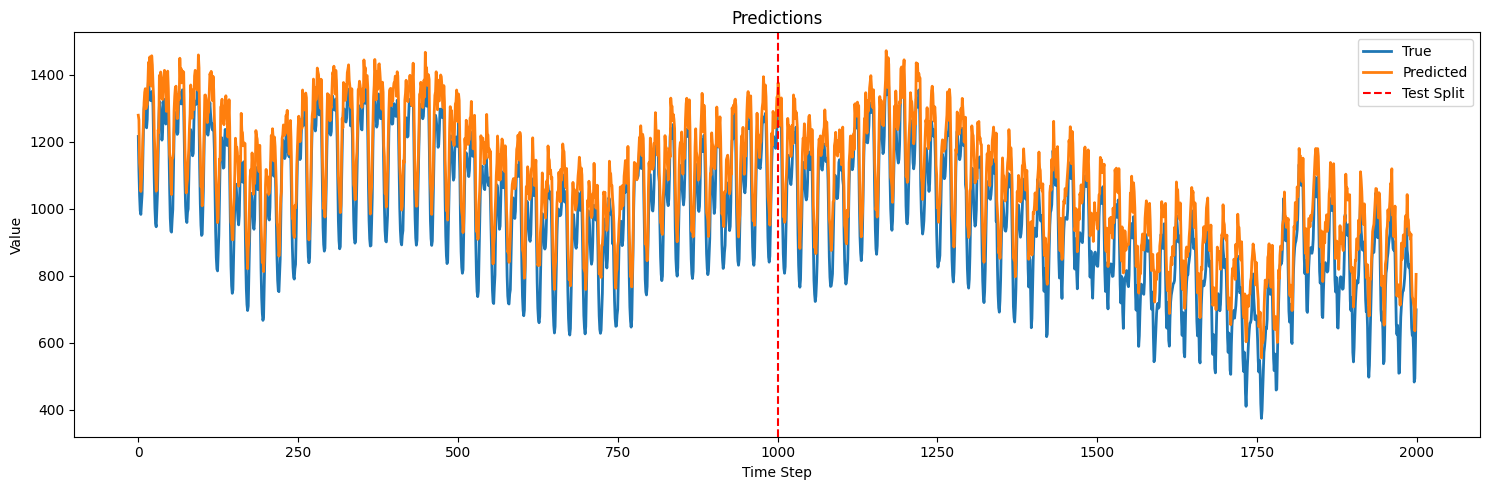

In [ ]:
plot_partial_predictions(
    y_true=results['y_true'],
    preds_dict=results['y_pred'],
    split_idx=100,
    group_title="Predictions",
    window_size=2000,  # Use the full available length
    start_idx=0
)

In [85]:
print(results['y_pred'])
print(results['y_true'])

[1279.4644  1265.5386  1137.73    ...  700.43414  750.94     618.5533 ]
[1216.0396  1113.44    1039.9702  ...  629.4996   538.6099   439.19977]
